In [2]:
import yfinance as yf
import pandas as pd
import os

In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
type(sp500)

pandas.core.frame.DataFrame

In [9]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [14]:
type(sp500.index)

pandas.core.indexes.base.Index

In [16]:
sp500.index = pd.to_datetime(sp500.index, utc=True)


In [17]:
sp500.index = sp500.index.date

In [18]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-10,5490.509766,5497.910156,5441.720215,5495.520020,3848180000,0.0,0.0
2024-09-11,5496.419922,5560.410156,5406.959961,5554.129883,3839450000,0.0,0.0
2024-09-12,5557.479980,5600.709961,5535.500000,5595.759766,3655070000,0.0,0.0
2024-09-13,5603.339844,5636.270020,5601.649902,5626.020020,3500790000,0.0,0.0


<Axes: >

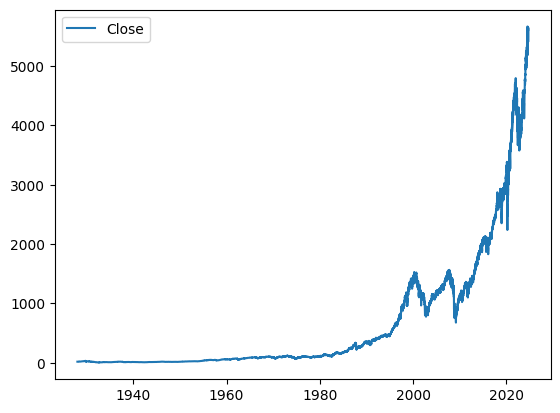

In [19]:
sp500.plot.line(y="Close", use_index=True)

In [20]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [21]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)


In [22]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [25]:
print(type(sp500.index))
sp500.index = pd.to_datetime(sp500.index)
print(type(sp500.index))


<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [26]:
sp500 = sp500.loc["1990-01-01":].copy()

In [27]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-09-10,5490.509766,5497.910156,5441.720215,5495.520020,3848180000,5554.129883,1
2024-09-11,5496.419922,5560.410156,5406.959961,5554.129883,3839450000,5595.759766,1
2024-09-12,5557.479980,5600.709961,5535.500000,5595.759766,3655070000,5626.020020,1
2024-09-13,5603.339844,5636.270020,5601.649902,5626.020020,3500790000,5633.089844,1


In [28]:
# why cant we use cross validation for time series data especially for stock market pred
sp500 = sp500.loc["1990-01-01":].copy()

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [30]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

np.float64(0.5714285714285714)

<Axes: >

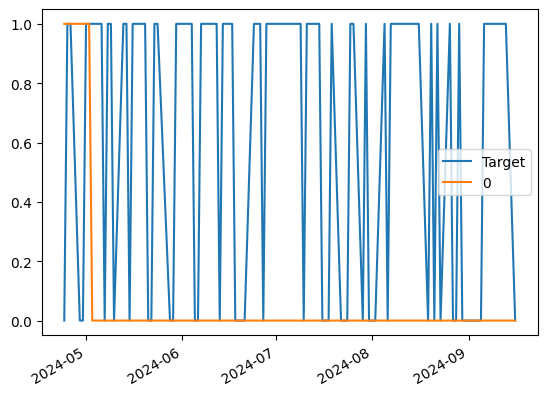

In [31]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [32]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [33]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [34]:
predictions = backtest(sp500, model, predictors)

In [35]:
predictions["Predictions"].value_counts()

Predictions
0    3647
1    2596
Name: count, dtype: int64

In [36]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5288906009244992)

In [37]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.53564
0    0.46436
Name: count, dtype: float64

In [38]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [39]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


In [40]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-10,5490.509766,5497.910156,5441.720215,5495.520020,3848180000,5554.129883,1,1.002231,2.0,1.002888,2.0,0.999330,34.0,1.100423,144.0,1.265038,526.0
2024-09-11,5496.419922,5560.410156,5406.959961,5554.129883,3839450000,5595.759766,1,1.005304,2.0,1.012325,3.0,1.009613,35.0,1.111192,144.0,1.277872,527.0
2024-09-12,5557.479980,5600.709961,5535.500000,5595.759766,3655070000,5626.020020,1,1.003734,2.0,1.016491,4.0,1.016803,35.0,1.118544,144.0,1.286765,528.0
2024-09-13,5603.339844,5636.270020,5601.649902,5626.020020,3500790000,5633.089844,1,1.002697,2.0,1.013972,5.0,1.021871,35.0,1.123537,145.0,1.293036,528.0


In [41]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
predictions = backtest(sp500, model, new_predictors)

In [44]:
predictions["Predictions"].value_counts()

Predictions
0.0    4397
1.0     846
Name: count, dtype: int64

In [45]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.574468085106383)

In [46]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.545298
0    0.454702
Name: count, dtype: float64

In [47]:

predictions

,Target,Predictions
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2024-09-10,1,1.0
2024-09-11,1,1.0
2024-09-12,1,1.0
2024-09-13,1,0.0
